**Description:** This notebook demonstrates the application of PIP-MYULA to the Bayesian matrix completion example.

In [1]:
#@title Load modules.

# Numpy and JAX for computations.
import numpy as np
import jax
import jax.numpy as jnp
import torch

# Pyplot for plots.
import matplotlib.pyplot as plt 

Import algorithms

In [2]:
# Algorithms
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))  
sys.path.append(project_root)

from matrix_completion.example_2.algorithms_cloud_theta import pip_myula_matrix_sparse_extra_parameter_one_sample

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

os.chdir(project_root)

2024-03-18 16:38:47.551256: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-18 16:38:47.551330: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-18 16:38:47.553347: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-18 16:38:50.275673: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.1.0) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


#### Example checker board matrices for X and normally distributed Theta

In [3]:
def checker_matrix_fix(size=(30, 2), a = (np.random.randint(6) -3), b = (np.random.randint(6) -3)):
    """Run alternating minimization on subsample of rank 2 matrix."""

    A = np.zeros(size)
    # Create rank 2 matrix with checkerboard pattern
    for i in range(0,size[0]):
        for j in range(0,size[1]):         
            if divmod(i, 2)[1]==0:
                A[i,j] += a 
            if divmod(i, 2)[1]==1:
                A[i,j] += -a
            if divmod(j, 2)[1]==0:
                A[i,j] += b
            if divmod(j, 2)[1]==1:
                A[i,j] += -b 
    #plot_decomposition(A)      
    return A

In [4]:
# Generate matrix X
num_matrices = 1
matrix_shape = (2, 100)
def generate_concatenated_matrices(matrix_shape=matrix_shape):   
    matrix = checker_matrix_fix(matrix_shape)
    matrix_sparse = matrix + np.random.normal(scale=0.5, size = matrix_shape)
    return matrix_sparse

# Example usage
result_matrix = generate_concatenated_matrices()
print(result_matrix.shape)  # Sanity check: should be (matrix_shape)

(2, 100)


In [5]:
singular_values = jnp.linalg.svd(result_matrix, compute_uv=False)
tr_norm = jnp.sum(jnp.abs(singular_values))
print(tr_norm, "Nuclear norm")
print(singular_values)

44.990967 Nuclear norm
[29.39617  15.594797]


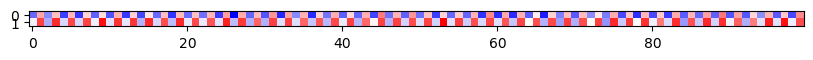

In [6]:
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
p = axs.imshow(result_matrix, cmap='bwr')


In [7]:
# Generate matrix Theta
theta_shape = (30, matrix_shape[0])
matrix_theta = np.random.normal(loc = 1.5, scale=0.25, size = theta_shape)

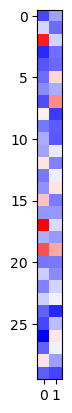

In [8]:
plt.imshow(matrix_theta, cmap='bwr')

In [9]:
# Obtain matrices Y multiplying X with the basis Theta
matrices_Y = jnp.tensordot(matrix_theta, result_matrix, axes=([1], [0]))

# Observation mask 
mask_observation = jax.random.randint(key = jax.random.PRNGKey(1), shape = matrices_Y.shape, minval = 0, maxval = 2)

observed_Y = jnp.where(mask_observation > 0, matrices_Y, 0)

dim_Y = np.sum(mask_observation)

In [10]:
# Sanity check for rank of matrices 
print(np.linalg.matrix_rank(matrices_Y))
singular_values = jnp.linalg.svd(matrices_Y, compute_uv=False)
tr_norm = jnp.sum(jnp.abs(singular_values))
print(tr_norm, "Nuclear norm")
print(singular_values)

2
370.2708 Nuclear norm
[3.4886691e+02 2.1403843e+01 2.9761841e-05 4.0424688e-06 3.7250118e-06
 3.4664083e-06 3.2682838e-06 2.9848368e-06 2.8702334e-06 2.7975909e-06
 2.6022137e-06 2.4853477e-06 2.3595455e-06 2.3289272e-06 2.2581405e-06
 2.1812866e-06 2.1573060e-06 2.0429216e-06 2.0019420e-06 1.8995561e-06
 1.8773620e-06 1.7066843e-06 1.6654044e-06 1.5699352e-06 1.5125726e-06
 1.3724134e-06 1.3542946e-06 1.2802204e-06 1.1295359e-06 1.0558459e-06]


Run algorithm

In [18]:
# Set approximation parameters:
h = 5e-2 # Step-size. 
K = 150  # Number of steps.
N = 10  # Number of particles.
gamma = 0.35 # Smoothing parameter

# Initialize parameter estimates:
a0 = np.array([1])  # Alpha.
b0 = np.array([0.5])  # Beta.
Theta0 = np.random.normal(b0, 0.5, (theta_shape[0], theta_shape[1], N))  # Basis matrix.

# Initialize particle cloud by sampling prior:'
X0 = np.random.normal(0, 0.5, (matrix_shape[0], matrix_shape[1], N))  
X0_sparse = X0
dim_Y = observed_Y.size

# Run algorithms:
a, b, Thetas, X, rel_error, rel_error_missing, log_density_vec, rel_error_theta = pip_myula_matrix_sparse_extra_parameter_one_sample(observed_Y, mask_observation, h, K, a0, b0, Theta0, X0_sparse, 
                                                                                      gamma, dim_Y, result_matrix, theta_true = matrix_theta)

  5%|▍         | 7/150 [00:00<00:12, 11.77it/s]

100%|██████████| 150/150 [00:11<00:00, 12.92it/s]


In [19]:
print(jnp.min(rel_error), "Min relative error across the steps")
print(jnp.min(rel_error_missing), "Min relative error of missing entries across the steps")
print(jnp.max(log_density_vec), "Maximum log-density across the steps")
print(jnp.min(rel_error_theta), "Min relative error of theta across the steps")

0.27834392 Min relative error across the steps
0.047027238 Min relative error of missing entries across the steps
-1340.7477 Maximum log-density across the steps
0.08939749 Min relative error of theta across the steps


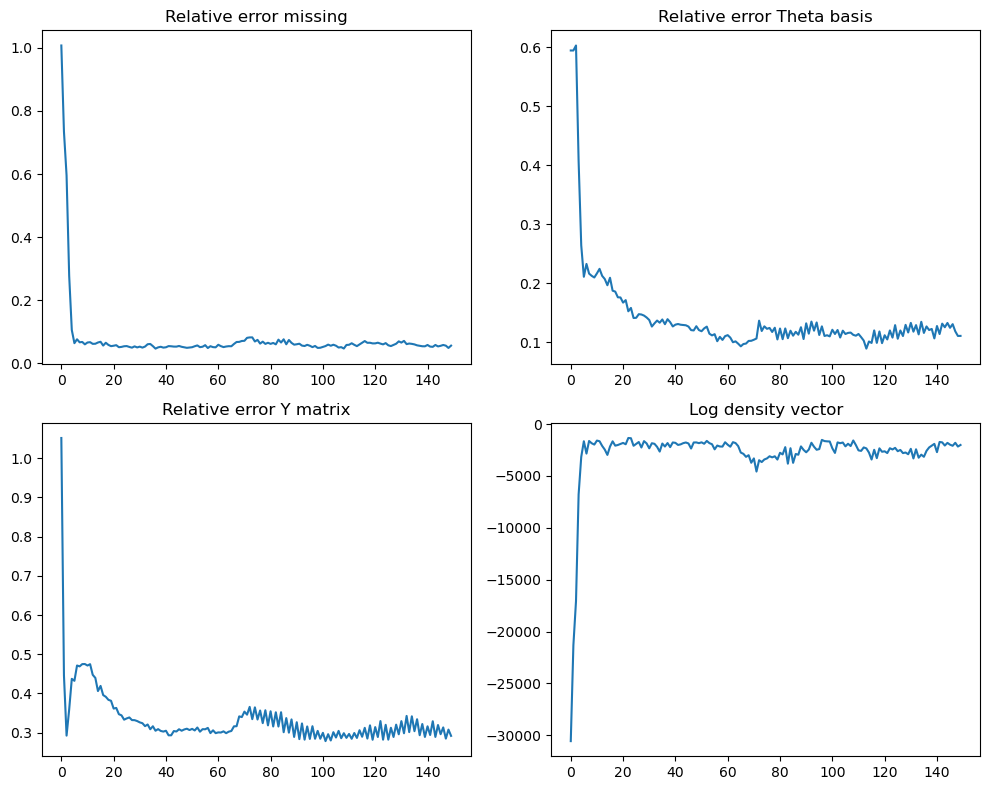

In [20]:
# Create a figure with 4 subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Plot 1
axs[0, 0].plot(rel_error_missing)
axs[0, 0].set_title('Relative error missing')

# Plot 2
axs[0, 1].plot(rel_error_theta)
axs[0, 1].set_title('Relative error Theta basis')

# Plot 3
axs[1, 0].plot(rel_error)
axs[1, 0].set_title('Relative error Y matrix')

# Plot 4
axs[1, 1].plot(log_density_vec)
axs[1, 1].set_title('Log density vector')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()

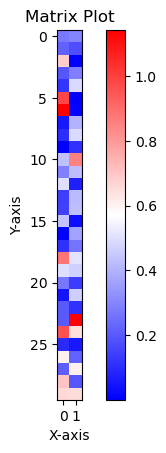

In [21]:
# Example matrix
matrixx = Thetas[:, :, 0]

# Plot the matrix
plt.imshow(np.abs(matrixx-matrix_theta), cmap='bwr')
plt.colorbar()  # Add color bar to show the scale
plt.title('Matrix Plot')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

(30, 100)


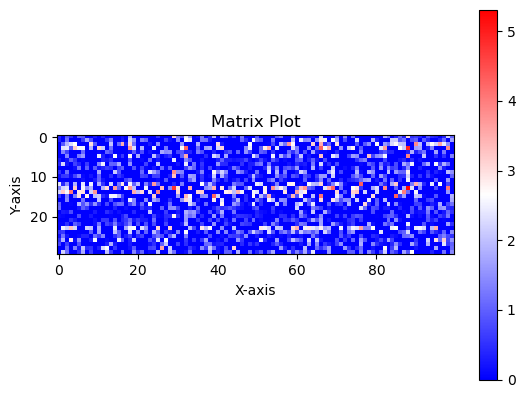

In [33]:
# Example matrix
i = 0
matrix_y = jnp.tensordot(Thetas[:, :, -1], X, axes=([1], [0]))[:,:,0]
print(matrix_y.shape)

# Plot the matrix
plt.imshow(np.abs((matrix_y-matrices_Y)*(1-mask_observation)), cmap='bwr')
plt.colorbar()  # Add color bar to show the scale
plt.title('Matrix Plot')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

In [42]:
# Sanity check for rank of matrices 
matrices_Y_recover = jnp.tensordot(Thetas[:, :, -1], X, axes=([1], [0]))[:, :, -1]

print(np.linalg.matrix_rank(matrices_Y_recover[:, :]))
singular_values = jnp.linalg.svd(matrices_Y_recover[:, :], compute_uv=False)
tr_norm = jnp.sum(jnp.abs(singular_values))
print(tr_norm, "Nuclear norm")
print(singular_values)
singular_values = jnp.linalg.svd(matrices_Y[:, :], compute_uv=False)
tr_norm = jnp.sum(jnp.abs(singular_values))
print(tr_norm, "Nuclear norm")
print(singular_values)

2
379.7769 Nuclear norm
[3.6021814e+02 1.9558680e+01 2.0775828e-05 4.3782079e-06 4.1088888e-06
 3.6568465e-06 3.4413538e-06 3.2068272e-06 3.0599624e-06 2.8640061e-06
 2.8243544e-06 2.7809076e-06 2.6264615e-06 2.4969218e-06 2.4049916e-06
 2.3204898e-06 2.1770782e-06 2.1022099e-06 2.0469397e-06 1.9745150e-06
 1.8459825e-06 1.7594191e-06 1.6666673e-06 1.5444444e-06 1.4822062e-06
 1.4397217e-06 1.3825918e-06 1.2560060e-06 1.1190392e-06 9.9881242e-07]
370.2708 Nuclear norm
[3.4886691e+02 2.1403843e+01 2.9761841e-05 4.0424688e-06 3.7250118e-06
 3.4664083e-06 3.2682838e-06 2.9848368e-06 2.8702334e-06 2.7975909e-06
 2.6022137e-06 2.4853477e-06 2.3595455e-06 2.3289272e-06 2.2581405e-06
 2.1812866e-06 2.1573060e-06 2.0429216e-06 2.0019420e-06 1.8995561e-06
 1.8773620e-06 1.7066843e-06 1.6654044e-06 1.5699352e-06 1.5125726e-06
 1.3724134e-06 1.3542946e-06 1.2802204e-06 1.1295359e-06 1.0558459e-06]


In [45]:
singular_values = jnp.linalg.svd(Thetas[:, :, -1], compute_uv=False)
tr_norm = jnp.sum(jnp.abs(singular_values))
print(singular_values)
print(tr_norm, "Trace norm recovered theta matrix")
singular_values = jnp.linalg.svd(matrix_theta, compute_uv=False)
tr_norm = jnp.sum(jnp.abs(singular_values))
print(singular_values)
print(tr_norm, "Trace norm true theta matrix")

[10.371783   2.7181919]
13.089975 Trace norm recovered theta matrix
[11.871032  1.372121]
13.243153 Trace norm true theta matrix
